## Training multi-modal

#### There are six parts: splitting the dataset, creating text prompts, choosing an image model (ResNet18 in this case), choosing a text model, designing and training the multimodal model, and testing and comparing. Conclusion and future work are at the end.

### step1: prepare datasets

In [ ]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_classes = ['airplane', 'automobile', 'bird', 'truck', 'deer', 'dog', 'frog']
zero_shot_classes = ['horse', 'cat', 'ship']
class_to_idx = {name: idx for idx, name in enumerate(dataset.classes)}

# Convert classes to indices
train_class_indices = [class_to_idx[cls] for cls in train_classes]
zero_shot_class_indices = [class_to_idx[cls] for cls in zero_shot_classes]

# Separate indices for each dataset split
train_indices = [i for i, (_, label) in enumerate(dataset) if label in train_class_indices]
zero_shot_indices = [i for i, (_, label) in enumerate(dataset) if label in zero_shot_class_indices]

# Split train_indices into actual train and test sets
split_ratio = 0.8
train_split_size = int(split_ratio * len(train_indices))
train_split_indices = train_indices[:train_split_size]
in_domain_test_indices = train_indices[train_split_size:]

train_data = Subset(dataset, train_split_indices)          # Training data
in_domain_test_data = Subset(dataset, in_domain_test_indices)  # In-domain test data (same classes as train)
zero_shot_test_data = Subset(dataset, zero_shot_indices)   # Zero-shot test data

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
in_domain_test_loader = DataLoader(in_domain_test_data, batch_size=32, shuffle=False)
zero_shot_test_loader = DataLoader(zero_shot_test_data, batch_size=32, shuffle=False)

print(f"Training set size: {len(train_data)}")
print(f"In-domain test set size: {len(in_domain_test_data)}")
print(f"Zero-shot test set size: {len(zero_shot_test_data)}")


Files already downloaded and verified
Training set size: 28000
In-domain test set size: 7000
Zero-shot test set size: 15000


### step2: generate descriptive text prompts

In [ ]:
def generate_detailed_text_descriptions(labels, dataset):
    detailed_descriptions = {
        "airplane": "An airplane with long wings extending out from a narrow body, typically seen with a cockpit at the front and engines attached to the wings. It has a sleek metallic surface, landing gear, and a tail fin. Often captured in the sky or on a runway.",
        "automobile": "A vehicle with four wheels, windows, and a metallic body. Usually has headlights at the front and a streamlined shape. Cars can be seen in various colors, with visible doors, side mirrors, and a glossy surface reflecting light.",
        "bird": "A small animal covered in feathers, with a rounded body, wings, and a pointed beak. Birds often have delicate claws and expressive eyes. The feather patterns and color combinations vary widely, often with small, vivid details in the wings or tail.",
        "cat": "A small, agile animal with soft fur, a long tail, and pointed ears. Cats have expressive eyes, sharp claws, and whiskers around their snout. Their fur can have stripes, spots, or a solid color, and they often appear crouched or lounging.",
        "deer": "A graceful animal with a slender body, long legs, and a short tail. Male deer have antlers that branch out, while females are typically without antlers. Their fur is usually a warm brown color with subtle white markings, particularly on the underbelly and tail.",
        "dog": "A furry, four-legged animal with a friendly face, ears that may be pointed or floppy, and a wagging tail. Dogs come in various sizes and colors, often with distinct facial markings, shiny eyes, and a sturdy body covered in fur.",
        "frog": "A small amphibian with smooth, moist skin and large, protruding eyes. Frogs have long, webbed hind legs for jumping, and their skin is often green, brown, or speckled. They are frequently seen near water, blending in with their surroundings.",
        "horse": "A large, muscular animal with a shiny coat, a long mane, and a tail that sways. Horses have long legs ending in hooves and a strong, elongated face with expressive eyes and large nostrils. Their coat color varies from brown to black, white, or gray.",
        "ship": "A large watercraft with a broad structure, often featuring tall masts, flags, and lifeboats along the sides. Ships have a prominent hull, often painted, and are seen on the ocean with waves around them, casting reflections on the water surface.",
        "truck": "A large vehicle with a boxy shape, a spacious cargo area at the back, and big, durable wheels. Trucks usually have a tall, prominent front with visible headlights, a cabin for the driver, and a sturdy, often metallic body."
    }

    descriptions = []
    for _, label in dataset:
        descriptions.append(detailed_descriptions[labels[label]])
    return descriptions
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Generate text descriptions for training, in-domain test, and zero-shot test datasets
train_texts = generate_detailed_text_descriptions(labels, train_data)
in_domain_test_texts = generate_detailed_text_descriptions(labels, in_domain_test_data)
zero_shot_test_texts = generate_detailed_text_descriptions(labels, zero_shot_test_data)

### step3: image model

Before running this code, make sure to save the `cifar10-resnet18.ckpt` file and copy its path to the corresponding location in the code to ensure it runs smoothly.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#if you use googlecolab to run this .ipynb, uploaded ckpt file and run this

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/resnet18-cifar10.ckpt", map_location=device)
model.load_state_dict(checkpoint, strict=False)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

Using cuda device


<ipython-input-31-cb850c2f2bb0>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/resnet18-cifar10.ckpt", map

### step4: text model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class TextModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1):
        super(TextModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)  # Embedding dropout for regularization

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)  # Add dropout after embedding layer
        lstm_out, _ = self.lstm(x)
        x = torch.mean(lstm_out, dim=1)
        x = self.fc(x)
        return x

def build_vocab(texts):
    words = set(word for text in texts for word in text.split())
    return {word: i for i, word in enumerate(words)}

vocab = build_vocab(train_texts)
vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 64
output_dim = 10

text_model = TextModel(vocab_size, embed_dim, hidden_dim, output_dim)
def texts_to_indices(texts, vocab):
    indices = []
    for text in texts:
        indices.append([vocab[word] for word in text.split() if word in vocab])
    return indices
train_indices = texts_to_indices(train_texts, vocab)
in_domain_test_indices = texts_to_indices(in_domain_test_texts, vocab)
zero_shot_test_indices = texts_to_indices(zero_shot_test_texts, vocab)

### step5: train multi-modal classifer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MultimodalModel(nn.Module):
    def __init__(self, image_model, text_model, combined_dim, hidden_dim, output_dim):
        super(MultimodalModel, self).__init__()
        self.image_model = image_model.to(device)
        self.text_model = text_model.to(device)
        for param in self.image_model.parameters():
            param.requires_grad = False

        self.image_fc = nn.Linear(10, combined_dim).to(device)
        self.text_fc = nn.Linear(10, combined_dim).to(device)
        self.attention = nn.MultiheadAttention(embed_dim=combined_dim, num_heads=2, batch_first=True).to(device)

        self.fc1 = nn.Linear(combined_dim * 2, hidden_dim).to(device)
        self.fc2 = nn.Linear(hidden_dim, output_dim).to(device)

    def forward(self, image, text):
        with torch.no_grad():
            image_output = self.image_model(image.to(device))
        text_output = self.text_model(text.to(device))

        image_output = self.image_fc(image_output)
        text_output = self.text_fc(text_output)

        combined_features = torch.stack((image_output, text_output), dim=1)
        attention_output, _ = self.attention(combined_features, combined_features, combined_features)
        combined = attention_output.reshape(attention_output.size(0), -1)
        x = nn.ReLU()(self.fc1(combined))
        output = self.fc2(x)

        return output

combined_dim = 128
hidden_dim = 64
output_dim = 10

multimodal_model = MultimodalModel(model, text_model, combined_dim, hidden_dim, output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(multimodal_model.parameters(), lr=0.001)
train_images = torch.stack([img for img, _ in train_data])
train_labels = torch.tensor([label for _, label in train_data])
train_texts_tensor = torch.nn.utils.rnn.pad_sequence([torch.tensor(t) for t in train_indices], batch_first=True)

train_dataset = TensorDataset(train_images, train_texts_tensor, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

num_epochs = 20
for epoch in range(num_epochs):
    multimodal_model.train()
    total_loss = 0
    for images, texts, labels in train_loader:
        images, texts, labels = images.to(device), texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = multimodal_model(images, texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
import os
save_path = '/content/drive/MyDrive/Colab Notebooks/multimodal_model.ckpt'
print(f"Saving model to {save_path}")
torch.save(multimodal_model.state_dict(), save_path)



Epoch 1/20, Loss: 0.0753
Epoch 2/20, Loss: 0.0043
Epoch 3/20, Loss: 0.0001
Epoch 4/20, Loss: 0.0000
Epoch 5/20, Loss: 0.0270
Epoch 6/20, Loss: 0.0349
Epoch 7/20, Loss: 0.0021
Epoch 8/20, Loss: 0.0091
Epoch 9/20, Loss: 0.0007
Epoch 10/20, Loss: 0.0338
Epoch 11/20, Loss: 0.0003
Epoch 12/20, Loss: 0.0186
Epoch 13/20, Loss: 0.0422
Epoch 14/20, Loss: 0.0227
Epoch 15/20, Loss: 0.0012
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0278
Epoch 18/20, Loss: 0.0393
Epoch 19/20, Loss: 0.0148
Epoch 20/20, Loss: 0.0017
Saving model to /content/drive/MyDrive/Colab Notebooks/multimodal_model.ckpt


### Step 6: Evaluation and Comparison

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 80.11%
Precision: 0.85
Recall: 0.80
F1-score: 0.82


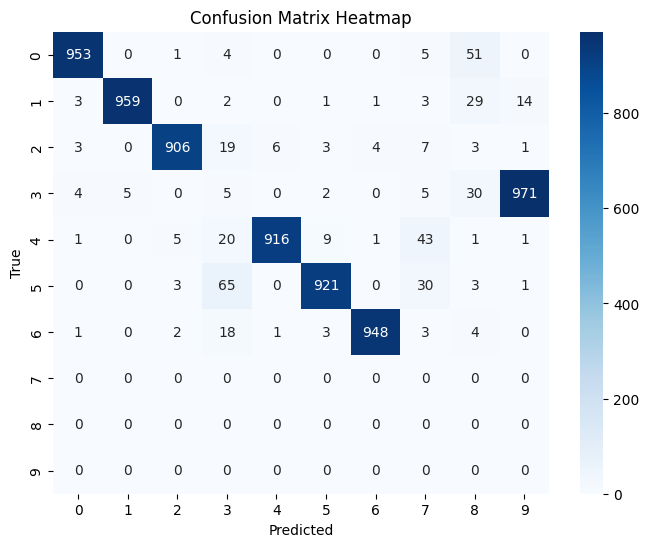

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.00%
Precision: 0.00
Recall: 0.00
F1-score: 0.00


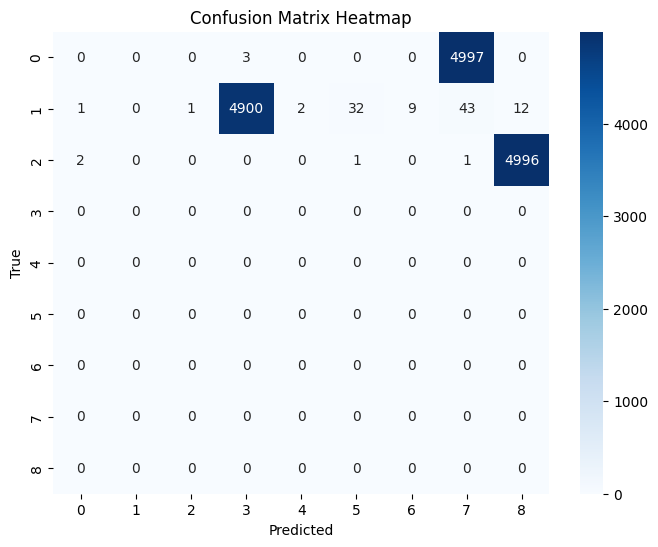

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 85.40%
Precision: 0.85
Recall: 0.85
F1-score: 0.85


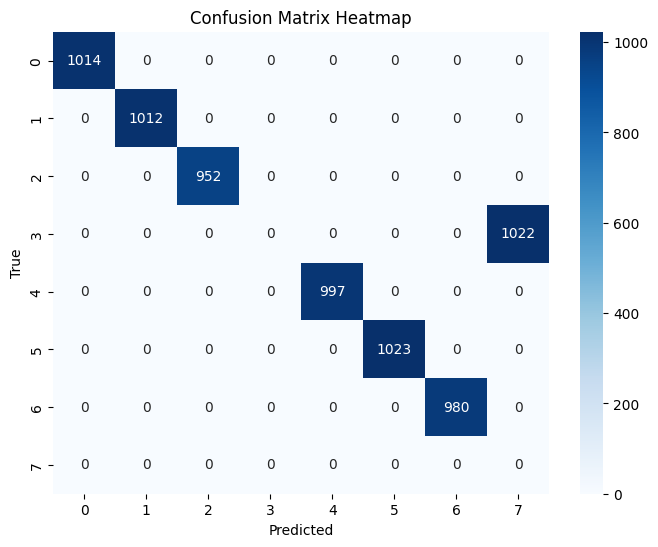

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 33.02%
Precision: 0.33
Recall: 0.33
F1-score: 0.33


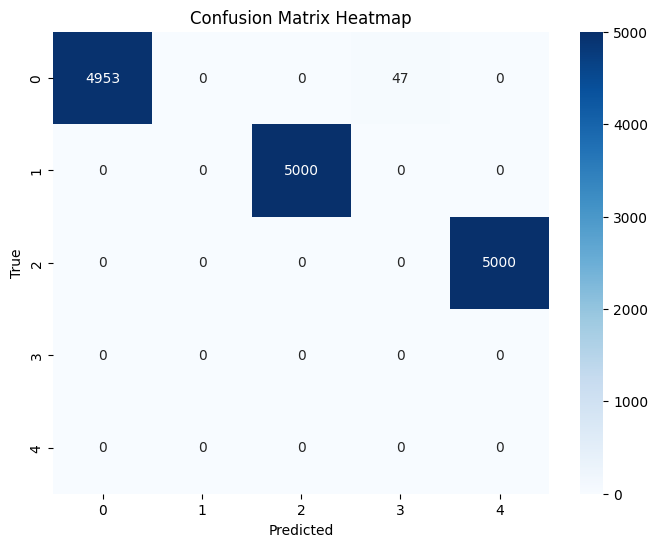

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def evaluate_model(model, data_loader, model_type="resnet"):
    model.eval()
    multimodal_model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, texts, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            if model_type == "resnet":
                outputs = model(images)
            else:
                texts = texts.to(device)
                outputs = model(images, texts)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return accuracy


in_domain_test_images = torch.stack([img for img, _ in in_domain_test_data])
in_domain_test_labels = torch.tensor([label for _, label in in_domain_test_data])
in_domain_test_texts_tensor = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(t) for t in in_domain_test_indices], batch_first=True
)

in_domain_test_label_map = {old_label: new_label for new_label, old_label in enumerate(train_class_indices)}
mapped_in_domain_test_labels = torch.tensor([in_domain_test_label_map[label.item()] for label in in_domain_test_labels])

in_domain_test_dataset = TensorDataset(in_domain_test_images, in_domain_test_texts_tensor, mapped_in_domain_test_labels)
in_domain_test_loader = DataLoader(in_domain_test_dataset, batch_size=32, shuffle=False)

zero_shot_test_images = torch.stack([img for img, _ in zero_shot_test_data])
zero_shot_test_labels = torch.tensor([label for _, label in zero_shot_test_data])
zero_shot_test_texts_tensor = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(t) for t in zero_shot_test_indices], batch_first=True
)

zero_shot_test_label_map = {old_label: new_label for new_label, old_label in enumerate(zero_shot_class_indices)}
mapped_zero_shot_test_labels = torch.tensor([zero_shot_test_label_map[label.item()] for label in zero_shot_test_labels])

zero_shot_test_dataset = TensorDataset(zero_shot_test_images, zero_shot_test_texts_tensor, mapped_zero_shot_test_labels)
zero_shot_test_loader = DataLoader(zero_shot_test_dataset, batch_size=32, shuffle=False)

# 1.ResNet18 in-domain test
model = model.to(device)
resnet18_accuracy_in_domain_test = evaluate_model(model, in_domain_test_loader, model_type="resnet")


# 2. ResNet18 Zero-shot test
resnet18_accuracy_zero_shot_test = evaluate_model(model, zero_shot_test_loader, model_type="resnet")


# 3. multi-modal in-domain test
multimodal_model = multimodal_model.to(device)
multimodal_accuracy_in_domain_test = evaluate_model(multimodal_model, in_domain_test_loader, model_type="multimodal")


# 4. multi-modal Zero-shot test
multimodal_accuracy_zero_shot_test = evaluate_model(multimodal_model, zero_shot_test_loader, model_type="multimodal")

